#### catatan: 
beberapa data taksonomi memang kosong dari NCBInya, misal data interaksi virus pycv malah terhubung ke genus capsicum bukan spesies capsicum. dan itu memang dari data GloBInya langsung

In [150]:
from tqdm import tqdm
from owlready2 import *
from pyrdf2vec import RDF2VecTransformer
from pyrdf2vec.graphs import KG, Vertex
from pyrdf2vec.embedders import FastText,Word2Vec
from pyrdf2vec.walkers import RandomWalker
from pyvis.network import Network
from sklearn.manifold import TSNE
from umap import UMAP
from SPARQLWrapper import SPARQLWrapper
from jcopml.plot import plot_missing_value

import plotly.express as px
import pandas as pd
import numpy as np
import requests
import os
import networkx as nx
import matplotlib.pyplot as plt

from standardization import getTaxonomy
from vectorReferenced import get_taxon_vector
from process import cek_bfs, nx_to_pyviz

In [151]:
acuan_='Bemisia' # vektor acuan
data_='pycv2' #data virus
bobot_ed=1;
bobot_dc=1;

In [152]:
# link obo ncbi
ncbi_link = os.getcwd()+'/../data/ncbitaxon.owl'

### input data

In [153]:
#1
#baca data
df_node=pd.read_csv('dari_praproses/'+data_+'_node.csv',index_col=0) 
df_edge=pd.read_csv('dari_praproses/'+data_+'_edge.csv',index_col=0)

In [154]:
df_node.shape

(767, 14)

In [155]:
df_node.columns

Index(['taxon_id', 'taxon_name', 'taxon_path', 'taxon_path_ids',
       'taxon_path_rank', 'taxon_rank', 'superkingdom', 'kingdom', 'phylum',
       'class', 'order', 'family', 'genus', 'species'],
      dtype='object')

### Input vektor

ada di dekat tahap embedding

# Pra Proses kolom takson kosong

masih ada kosong, karena kewajiban tidak boleh kosong hanya untuk proses disambiguasi. 
Maka jika setelah disambiguasipun tda dapat spesies, jadinya tetap kosong. 

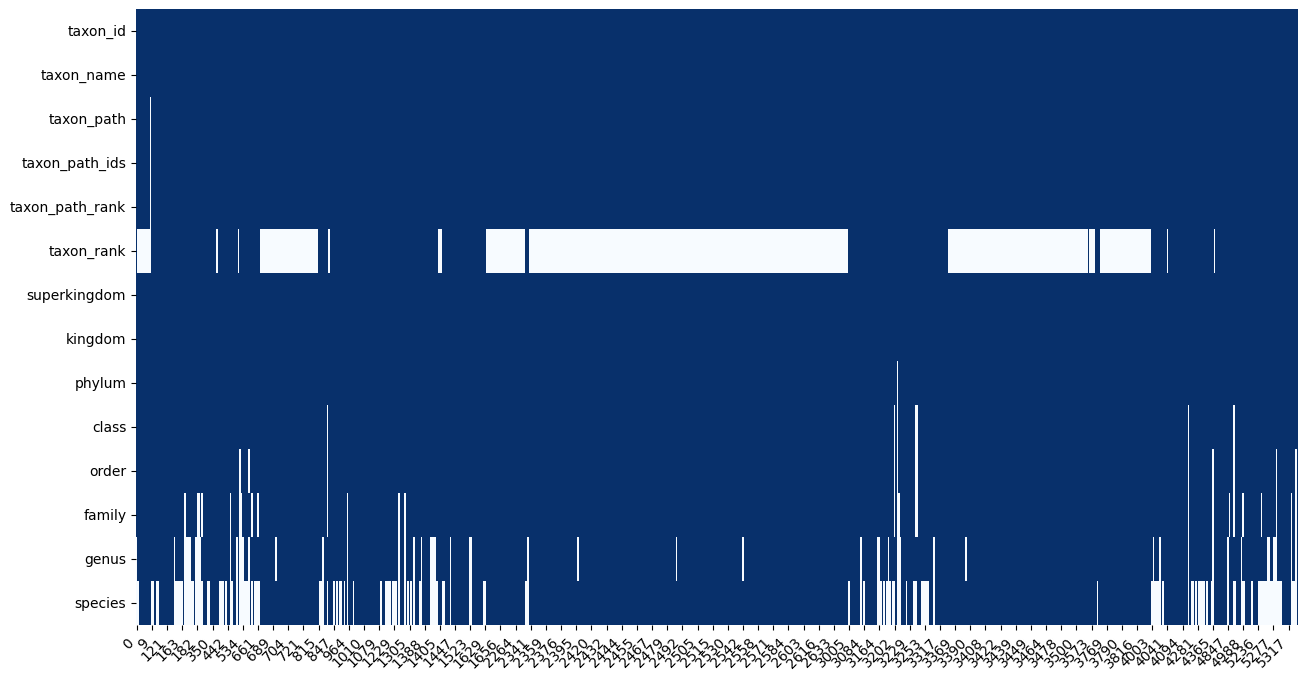

In [156]:
plot_missing_value(df_node)

Isi kolom takson kosong dengan data disamping kirinya (spesies kosong -> isi dengan genus). kalau superkingdom samping kanan.

In [157]:
#2
#isi data koson
takson=[
    'superkingdom','kingdom','phylum','class','order','family','genus','species'
]

for x,i in enumerate(takson):
    if (i!='superkingdom'): #selain superkingdom update dengan data sebelumnya
        for idx, row in df_node[pd.isnull(df_node[i])].iterrows():
            df_node.loc[idx,[i]] = row[takson[x-1]]+'^'+i
    else: 
        for idx, row in df_node[pd.isnull(df_node[i])].iterrows():
            df_node.loc[idx,[i]] = row[takson[x+1]]+'^'+i

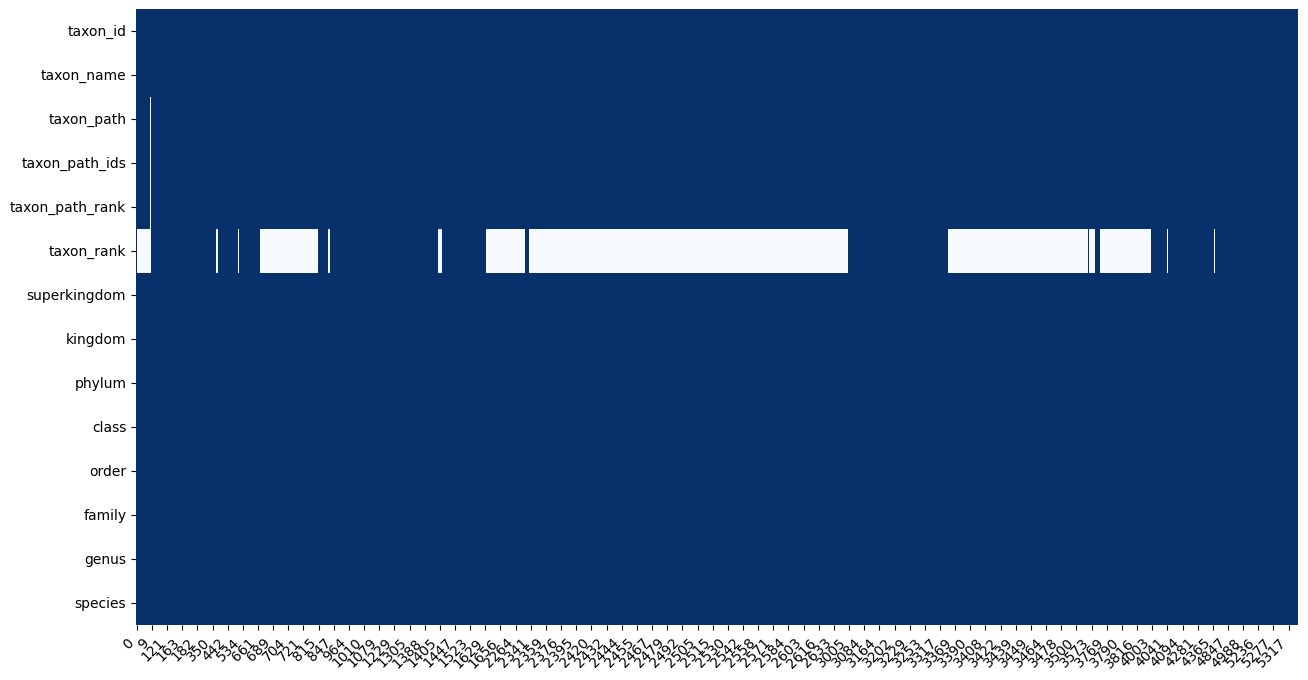

In [158]:
plot_missing_value(df_node)

In [159]:
df_node

,taxon_id,taxon_name,taxon_path,taxon_path_ids,taxon_path_rank,taxon_rank,superkingdom,kingdom,phylum,class,order,family,genus,species
0,NCBI:16739,Piperaceae,Plantae | Tracheophyta | Magnoliopsida | Piper...,GBIF:6 | GBIF:7707728 | GBIF:220 | GBIF:404 | ...,kingdom | phylum | class | order | family,family,NCBI:2759_Eukaryota,NCBI:33090_Viridiplantae,NCBI:35493_Streptophyta,NCBI:3398_Magnoliopsida,NCBI:16736_Piperales,NCBI:16739_Piperaceae,NCBI:16739_Piperaceae^genus,NCBI:16739_Piperaceae^genus^species
1,NCBI:4071,Capsicum,root | cellular organisms | Eukaryota | Viridi...,NCBI:1 | NCBI:131567 | NCBI:2759 | NCBI:33090 ...,null | null | superkingdom | kingdom | phylum ...,NaN,NCBI:2759_Eukaryota,NCBI:33090_Viridiplantae,NCBI:35493_Streptophyta,NCBI:3398_Magnoliopsida,NCBI:4069_Solanales,NCBI:4070_Solanaceae,NCBI:4071_Capsicum,NCBI:4071_Capsicum^species
2,NCBI:4072,Capsicum annuum,root | cellular organisms | Eukaryota | Viridi...,NCBI:1 | NCBI:131567 | NCBI:2759 | NCBI:33090 ...,null | null | superkingdom | kingdom | phylum ...,NaN,NCBI:2759_Eukaryota,NCBI:33090_Viridiplantae,NCBI:35493_Streptophyta,NCBI:3398_Magnoliopsida,NCBI:4069_Solanales,NCBI:4070_Solanaceae,NCBI:4071_Capsicum,NCBI:4072_Capsicum annuum
3,NCBI:40321,Capsicum annuum var. annuum,root | cellular organisms | Eukaryota | Viridi...,NCBI:1 | NCBI:131567 | NCBI:2759 | NCBI:33090 ...,null | null | superkingdom | kingdom | phylum ...,NaN,NCBI:2759_Eukaryota,NCBI:33090_Viridiplantae,NCBI:35493_Streptophyta,NCBI:3398_Magnoliopsida,NCBI:4069_Solanales,NCBI:4070_Solanaceae,NCBI:4071_Capsicum,NCBI:4072_Capsicum annuum
4,NCBI:4081,Solanum lycopersicum,root | cellular organisms | Eukaryota | Viridi...,NCBI:1 | NCBI:131567 | NCBI:2759 | NCBI:33090 ...,null | null | superkingdom | kingdom | phylum ...,NaN,NCBI:2759_Eukaryota,NCBI:33090_Viridiplantae,NCBI:35493_Streptophyta,NCBI:3398_Magnoliopsida,NCBI:4069_Solanales,NCBI:4070_Solanaceae,NCBI:4107_Solanum,NCBI:4081_Solanum lycopersicum
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5382,NCBI:5114,Diaporthales,Fungi | Ascomycota | Sordariomycetes | Diaport...,EOL:5559 | EOL:5577 | EOL:2858320 | EOL:5612 |...,kingdom | phylum | class | order | null | genus,order,NCBI:2759_Eukaryota,NCBI:4751_Fungi,NCBI:4890_Ascomycota,NCBI:147550_Sordariomycetes,NCBI:5114_Diaporthales,NCBI:5114_Diaporthales^family,NCBI:5114_Diaporthales^family^genus,NCBI:5114_Diaporthales^family^genus^species
5397,NCBI:66735,Diplodia,Fungi | Ascomycota | Dothideomycetes | Botryos...,EOL:5559 | EOL:5577 | EOL:2860895 | EOL:665991...,kingdom | phylum | class | order | family | genus,genus,NCBI:2759_Eukaryota,NCBI:4751_Fungi,NCBI:4890_Ascomycota,NCBI:147541_Dothideomycetes,NCBI:451869_Botryosphaeriales,NCBI:45131_Botryosphaeriaceae,NCBI:66735_Diplodia,NCBI:66735_Diplodia^species
5400,NCBI:34399,Phomopsis,Fungi | Ascomycota | Sordariomycetes | Diaport...,EOL:5559 | EOL:5577 | EOL:2858320 | EOL:5612 |...,kingdom | phylum | class | order | family | genus,genus,NCBI:2759_Eukaryota,NCBI:4751_Fungi,NCBI:4890_Ascomycota,NCBI:147550_Sordariomycetes,NCBI:5114_Diaporthales,NCBI:5117_Valsaceae,NCBI:34399_Phomopsis,NCBI:34399_Phomopsis^species
5427,NCBI:6933,Acari,Animalia | Bilateria | Protostomia | Ecdysozoa...,EOL:1 | EOL:3014411 | EOL:10459935 | EOL:88807...,kingdom | subkingdom | infrakingdom | superphy...,subclass,NCBI:2759_Eukaryota,NCBI:33208_Metazoa,NCBI:6656_Arthropoda,NCBI:6854_Arachnida,NCBI:6854_Arachnida^order,NCBI:6854_Arachnida^order^family,NCBI:6854_Arachnida^order^family^genus,NCBI:6854_Arachnida^order^family^genus^species


# Pengelompokan

In [160]:
# Binning of the data based on serangga, virus, tanaman, nogroup
filter_tanaman = df_node['kingdom']=='NCBI:33090_Viridiplantae' 
filter_virus = (
    (df_node['superkingdom']=='NCBI:10239_Viruses')
    | (df_node.taxon_name.str.contains(r'\b(virus\w*|\w*virus)\b',case=False))
    | (df_node.taxon_path.str.contains(r'\b(virus\w*|\w*virus)\b', case=False)) 
    #jika berawalan atau berakhiran kata virus
)
filter_serangga = df_node['class']=='NCBI:50557_Insecta' 
# df_node['kingdom']=='NCBI:33208_Metazoa' and (df_node['phylum']=='NCBI:6656_Arthropoda' and 
#ini jadi dilema, ada kalau ingin memasukan artropoda lain misal, laba2 maka pake or. untuk saat ini fokus ke insect

df_node.loc[filter_tanaman, ['group','color']] = ["tanaman",'#1f922b'] #hijau
df_node.loc[filter_virus, ['group','color']] = ['virus','#671f92'] #ungu
df_node.loc[filter_serangga, ['group','color']] = ['serangga','#b22222'] #merah
df_node.loc[(
    (filter_tanaman==False) & 
    (filter_virus==False) &
    (filter_serangga==False) 
    ),['group','color']] = ['nogroup','#EADDCA'] #abu-abu

/var/folders/b9/v73gyxys1djbgjy3c8c3cfwm0000gn/T/ipykernel_9424/3305061556.py:5: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.

/var/folders/b9/v73gyxys1djbgjy3c8c3cfwm0000gn/T/ipykernel_9424/3305061556.py:6: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



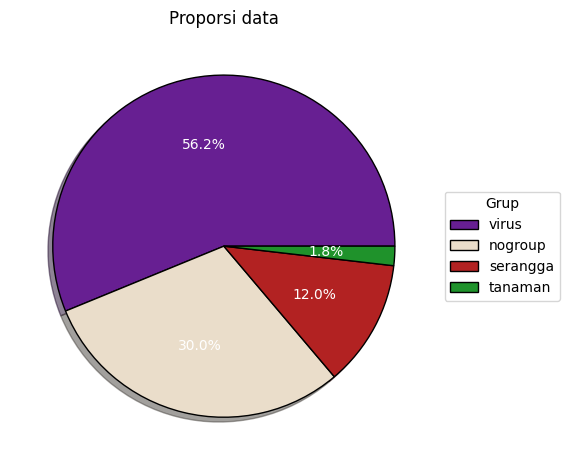

In [161]:
data = df_node.groupby(['group','color']).agg({'group': ['count'], }).reset_index().sort_values(
    ('group', 'count'),ascending=False
).reset_index(drop=True).values
labels = [i[0] for i in data]
colors = [i[1] for i in data]
slices = [i[2] for i in data]

plt.style.use("default")

wedges, texts, autotexts = plt.pie(
    slices, 
    colors=colors, 
    #labels=slices,
    wedgeprops={'edgecolor': 'black'}, 
#     explode=[0,0.1,0,0],
    shadow=True,
    autopct='%1.1f%%',
    textprops=dict(color="w")
)

plt.legend(
    wedges,
    labels,
    title="Grup",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

plt.title("Proporsi data")
plt.tight_layout()
plt.show()

In [162]:
#tampilkan semua
df_node.groupby(['group','kingdom']).agg({'group': ['count'], })

group
                                    count
group    kingdom                         
nogroup  NCBI:33208_Metazoa            39
         NCBI:4751_Fungi              191
serangga NCBI:33208_Metazoa            92
tanaman  NCBI:33090_Viridiplantae      14
virus    NCBI:2732092_Shotokuvirae    257
         NCBI:2732396_Orthornavirae   169
         NCBI:2732397_Pararnavirae      5

#### tampilkan no group
yang bukan serangga (kelas insect) tidak terfilter di praproses (cuma dari filumnya arthropoda). tidak apa, nanti di pas konversi ini semua akan dimasukan ke no group

In [163]:
df_node[df_node['group']=="nogroup"].groupby(['kingdom','phylum']).agg({'kingdom': ['count'], })

kingdom
                                                count
kingdom            phylum                            
NCBI:33208_Metazoa NCBI:6073_Cnidaria               2
                   NCBI:6231_Nematoda              27
                   NCBI:6340_Annelida               1
                   NCBI:6656_Arthropoda             5
                   NCBI:7711_Chordata               4
NCBI:4751_Fungi    NCBI:1913637_Mucoromycota        4
                   NCBI:1913638_Zoopagomycota       1
                   NCBI:4751_Fungi^phylum           1
                   NCBI:4761_Chytridiomycota        1
                   NCBI:4890_Ascomycota           159
                   NCBI:5204_Basidiomycota         25

# Konversi graf Network X
mulai disini akan digunakan taksonomi bahasa indonesia pada data.

In [164]:
#3
#networkx
gnx = nx.MultiDiGraph()
#node
for i,a in df_node.iterrows():
    #mulai disini akan digunakan taksonomi bahasa indonesia pada data.
    gnx.add_node(
        a['taxon_id'],
        label=a['taxon_name'],
        superkingdom=a['superkingdom'],
        kingdom=a['kingdom'],
        filum=a['phylum'],
        kelas=a['class'],
        ordo=a['order'],
        famili=a['family'],
        genus=a['genus'],
        spesies=a['species'],
        group=a['group'],
        color=a['color'],
    )
#edge
for i,a in df_edge.iterrows():
    gnx.add_edge(
        a['source_taxon_id'],
        a['target_taxon_id'],
        label=a['interaction_type'],
    )

In [165]:
# tampil jumlah anggota group
nodesAt5 = {}
for i in ['virus','tanaman','serangga','nogroup']:
    nodesAt5[i]=[]
    for (p, d) in gnx.nodes(data=True):
        if d['group'] == i:
            nodesAt5[i].append(d)
        
print('virus :', len(nodesAt5['virus']))
print('tanaman :', len(nodesAt5['tanaman']))
print('serangga :', len(nodesAt5['serangga']))
print('nogroup :', len(nodesAt5['nogroup']))

virus : 431
tanaman : 14
serangga : 92
nogroup : 230


In [166]:
# len(nx.get_node_attributes(G, "color").values())
len(gnx.nodes)

767

In [ ]:
G=gnx

fig, ax = plt.subplots(figsize=(20, 20))

# Generate layout for visualization
# pos = nx.kamada_kawai_layout(G)
# pos = nx.spring_layout(G)
pos = nx.nx_agraph.graphviz_layout(G, prog="neato", args="")

# Visualize graph components
nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color='g')
nx.draw_networkx_nodes(G, pos, node_color=list(nx.get_node_attributes(G, "color").values()), alpha=0.9)

#node label
# for i in ['#b22222','#671f92','#1f922b','#EADDCA']: # filtering dengan bedakan warna node
#     label_options = {"ec": i, "fc": 'white', "alpha": 0.7}
#     nx.draw_networkx_labels(
#         nx.subgraph_view(G, filter_node=lambda n1: G.nodes(data=True)[n1].get("color", True) == i),
#         pos, 
#         font_size=10, 
#         bbox=label_options
#     )

#edge labels
edge_labels={x:i for i,x in zip(nx.get_edge_attributes(G, "label").values(),G.edges())}
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


# Title/legend
font = {"fontname": "Helvetica", "color": "k", "fontweight": "bold", "fontsize": 14}
ax.set_title("Interaksi Tanaman-Serangga-Virus", font)
# Change font color for legend
font["color"] = "r"

ax.text(
    0.80,
    0.10,
    "hijau = Tanaman",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)
ax.text(
    0.80,
    0.08,
    "merah = Serangga",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

ax.text(
    0.80,
    0.06,
    "ungu = Virus",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

ax.text(
    0.80,
    0.04,
    "abu-abu = Nogroup",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

# Resize figure for label readibility
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.show()

# Analisis CM

### Degree centrality

Pilihan centrality yang bisa :
1. degree_centrality()
2. pagerank(gnx)
3. betweenness_centrality(gnx)

In [ ]:
#4 
# Degree Centrality
results = nx.degree_centrality(gnx)
allnodes = gnx.nodes
dc_serangga=[]
for node_id, rank in sorted(results.items(), key=lambda item: item[1], reverse=True):
    if allnodes[node_id]['group'] in ['serangga']:
        label = gnx.nodes[node_id]['label']
        dc_serangga.append((rank, label, node_id))

In [ ]:
dc_serangga

[(0.01174934725848564, 'Bombus', 'NCBI:28641'),
 (0.00783289817232376, 'Halictidae', 'NCBI:77572'),
 (0.006527415143603133, 'Bombus terrestris', 'NCBI:30195'),
 (0.005221932114882507, 'Contarinia maculipennis', 'NCBI:224263'),
 (0.005221932114882507, 'Silverleaf whitefly', 'NCBI:7038'),
 (0.005221932114882507, 'Wasmannia auropunctata', 'NCBI:64793'),
 (0.005221932114882507, 'Bombus impatiens', 'NCBI:132113'),
 (0.005221932114882507, 'Thrips parvispinus', 'NCBI:1350418'),
 (0.005221932114882507, 'Lasioglossum', 'NCBI:88467'),
 (0.00391644908616188, 'Neoleucinodes elegantalis', 'NCBI:1511177'),
 (0.00391644908616188, 'Helicoverpa armigera', 'NCBI:29058'),
 (0.00391644908616188, 'Spodoptera littoralis', 'NCBI:7109'),
 (0.00391644908616188, 'Silver Y', 'NCBI:254363'),
 (0.00391644908616188, 'Spodoptera litura', 'NCBI:69820'),
 (0.00391644908616188, 'Epitrix subcrinita', 'NCBI:1191541'),
 (0.00391644908616188, 'Nomia', 'NCBI:178049'),
 (0.00391644908616188, 'Frankliniella occidentalis', 'NC

In [ ]:
print('total serangga', len(dc_serangga))

total serangga 92


### cek atribut

In [171]:
tertinggi=dc_serangga[0][2] #ncbi id
allnodes[tertinggi]

{'label': 'Bombus',
 'superkingdom': 'NCBI:2759_Eukaryota',
 'kingdom': 'NCBI:33208_Metazoa',
 'filum': 'NCBI:6656_Arthropoda',
 'kelas': 'NCBI:50557_Insecta',
 'ordo': 'NCBI:7399_Hymenoptera',
 'famili': 'NCBI:7458_Apidae',
 'genus': 'NCBI:28641_Bombus <genus>',
 'spesies': 'NCBI:28641_Bombus <genus>^species',
 'group': 'serangga',
 'color': '#b22222'}

### Traversal : Cek BFS node hasil
ambil relasi pertama disekitar node hasil. Catatan : tidak menggambarkan degree (jumlah edge), karena bisa jadi ada satu pasang node yang sama punya byk relasi. Lebih ke melihat node apa dia terkait.

In [172]:
cek_bfs(gnx, tertinggi)

Bombus NCBI:28641 --> Capsicum NCBI:4071
Bombus NCBI:28641 --> Capsicum annuum NCBI:4072
Bombus NCBI:28641 --> Solanum lycopersicum NCBI:4081
Bombus NCBI:28641 --> Solanum melongena NCBI:4111


# PyViz visual

In [173]:
# nt=nx_to_pyviz(gnx)
# nt.show("tmp.virus_cabe.html")

# Embedding

### Input vektor Acuan

In [175]:
# def call_wiki_api(item):
#   try:
#     url = f"https://www.wikidata.org/w/api.php?action=wbsearchentities&search={item}&language=en&format=json"
#     data = requests.get(url).json()
#     # Return the first id (Could upgrade this in the future)
#     return data['search'][0]['id']
#   except:
#     return False

# def cek_vector_wiki_id(acuan_):    
#     id_=call_wiki_api(acuan_)
#     if not id_:
#         return False
    
#     format_='json'
#     endpoint_url='https://query.wikidata.org/sparql'
#     query="""
#         SELECT ?patogenLabel ?rankLabel ?ncbiLabel 
#         WHERE {
#             wd:"""+id_+""" wdt:P105 ?rank.
#             wd:"""+id_+""" wdt:P685 ?ncbi.
#             wd:"""+id_+""" wdt:P225 ?patogen.

#           SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
#         }
#         """
    
#     #querying
#     spw=SPARQLWrapper(endpoint_url)
#     spw.setQuery(query)
#     spw.setReturnFormat(format_)
#     hasil=spw.query().convert()
    
#     if(not hasil['results']['bindings']):
#         print("tidak ditemukan id: ",id_)
#         return False
    
#     hasil=hasil['results']['bindings'][0]
    
#     if 'ncbiLabel' in hasil:        
#         return (hasil['patogenLabel']['value'],
#                 hasil['rankLabel']['value'],
#                 "NCBI:"+hasil['ncbiLabel']['value'])
#     else: 
#         print("tidak ada id NCBI")
#         return False



# # untuk vector
# def get_taxon_vector(acuan_, obo):
#     cek = cek_vector_wiki_id(acuan_) #(Aphididae, family, NCBI:27482)
#     if not cek:
#         return False

#     #langsung pake bahasa indonesia karena di graf nanti akan pake bahasa indonesia
#     taxon_dict={
#         'superkingdom':'superkingdom',
#         'kingdom':'kingdom',
#         'phylum':'filum',
#         'class':'kelas',
#         'order':'ordo',
#         'family':'famili',
#         'genus':'genus',
#         'species':'spesies'
#     }
#     data=[]
#     for nama,rank,kode in getTaxonomy(cek[2],obo):
#         #nama=nama.replace(" ","-")
#         if rank in ['superkingdom','kingdom','phylum','class','order','family','genus','species']:
#             data.append((taxon_dict[rank],kode+'_'+nama)) #('family', 'NCBI:27482_Aphididae')
#     return data

In [176]:
#5
# Ambil NCBI OBO
onto = get_ontology(ncbi_link)
onto.load()
obo = onto.get_namespace('http://purl.obolibrary.org/obo/')

# data acuan
data_acuan=get_taxon_vector(acuan_,obo)
data_acuan

[('genus', 'NCBI:7037_Bemisia'),
 ('famili', 'NCBI:7036_Aleyrodidae'),
 ('ordo', 'NCBI:7524_Hemiptera'),
 ('kelas', 'NCBI:50557_Insecta'),
 ('filum', 'NCBI:6656_Arthropoda'),
 ('kingdom', 'NCBI:33208_Metazoa'),
 ('superkingdom', 'NCBI:2759_Eukaryota')]

### Konversi node networkx ke RDF

In [177]:
#6
#konversi node networkx ke RDF
URL = "http://pyRDF2Vec"
CUSTOM_KG = KG()

takson=[i[0] for i in data_acuan]
for i in ["superkingdom","kingdom","filum","kelas"]:
    takson.remove(i) 

# memasukan RDF serangga acuan
subj = Vertex(f"{URL}#SERANGGA_ACUAN")
for i,j in data_acuan:
    if(i not in ["superkingdom","kingdom","filum","kelas"]):
        j = j.replace(' ','-')
        obj = Vertex((URL+"#"+j))
        pred = Vertex((URL+"#"+i), predicate=True, vprev=subj, vnext=obj)
        #pred = Vertex((URL+"#taxon_path_ids"), predicate=True, vprev=subj, vnext=obj)
        CUSTOM_KG.add_walk(subj, pred, obj)

# proses konversi 
for index,data in gnx.nodes(data=True):
    if(data['group']=='serangga'): #jika serangga
        subj = Vertex(URL+"#"+index)
        for i in takson:
            #if(isinstance(data[i], str)): #jika dia string atau tidak nan/kosong.
            #if(i not in ["superkingdom","kingdom","filum","kelas"]):
                id_takson=data[i].replace(' ','-')#.split('_')[0]
                obj = Vertex((URL+"#"+id_takson))
                pred = Vertex((URL+"#"+i), predicate=True, vprev=subj, vnext=obj)
                #pred = Vertex((URL+"#taxon_path_ids"), predicate=True, vprev=subj, vnext=obj)
                CUSTOM_KG.add_walk(subj, pred, obj)
# CUSTOM_KG.literals=[
#         [f"{URL}#taxon_path_ids"],
#     ]
CUSTOM_KG.literals = [[URL+"#"+i] for i in takson]

kedekatan patogen menggunakan taxonomy

package pyrdf2vec
- link papernya https://arxiv.org/pdf/2205.02283.pdf
- link dokumentasinya https://pyrdf2vec.readthedocs.io/en/latest/readme.html#use-a-knowledge-graph

In [178]:
#7
#embedding
# Ensure the determinism of this script by initializing a pseudo-random number.
RANDOM_STATE = 22
transformer = RDF2VecTransformer(
    # Use one worker threads for Word2Vec to ensure random determinism.
    # Must be used with PYTHONHASHSEED.
    Word2Vec(epochs=1000),
    # Extract a maximum of 10 walks of a maximum depth of 4 for each entity
    # using two processes and use a random state to ensure that the same walks
    # are generated for the entities.
    walkers=[RandomWalker(2, 5, n_jobs=2, with_reverse=False, random_state=RANDOM_STATE)],
    #verbose=1,
)
# transformer = RDF2VecTransformer(verbose=1)
# list entity yang akan diembedd. serangga acuan urutan terakhir
ent = [ URL+"#"+index for index,data in gnx.nodes(data=True) if(data['group']=='serangga') ] #jika serangga
ent.append(f"{URL}#SERANGGA_ACUAN")
# Fit the transformer to the knowledge graph and the entities.
embeddings, _ = transformer.fit_transform(
    CUSTOM_KG, #the KG
    ent, #entity
)

Reduce dimensional

In [179]:
# transformer._entities

In [180]:
# Reduce the dimensions of entity embeddings to represent them in a 2D plane.
X= UMAP().fit_transform(embeddings)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


AttributeError: module 'numba.np.ufunc.omppool' has no attribute 'set_parallel_chunksize'

In [ ]:
df_umap=pd.DataFrame(X,columns=['umap1','umap2'])


text=[]
for x in transformer._entities:
    if(x!="http://pyRDF2Vec#SERANGGA_ACUAN"):
        text.append(gnx.nodes[x.split("#")[-1]]['label']+gnx.nodes[x.split("#")[-1]]['ordo'].split('_')[-1])
    else:
        text.append(x)
df_umap['text']=text

# # gnx.nodes[x.split("#")[-1]]['label']
# df_umap['text']=list(map(lambda x: x.split("#")[-1],transformer._entities))

In [ ]:
fig = px.scatter(df_umap, x='umap1',y='umap2',text='text')
fig.update_traces(textposition='top center')
fig.update_layout(
    height=650,
    title_text='reduced word2vec visualization'
)
fig.show()

In [ ]:
# allnodes['NCBI:115274']

In [ ]:
for i,z in zip(transformer._entities, X):
    print(i,z)

In [ ]:
_

In [ ]:
dc_serangga[0][1]

## Hitung Euclidean Distance

Bikin dataframe

In [ ]:
#8
#euclidean distance

# buat dataframe
data_to_count=pd.DataFrame(embeddings, columns=list(range(0,100)))

# buat kolom label
ent=[data['label'] for index,data in gnx.nodes(data=True) if(data['group']=='serangga')] #jika serangga
ent.append("#SERANGGA_ACUAN")
data_to_count['label']=ent

#buat kolom entity
data_to_count['entity']=[i.replace("http://pyRDF2Vec#","") for i in transformer._entities]

# buat kolom hasil dc
for idx,row in data_to_count.iterrows(): #jika serangga acuan maka DC di isi nilai 1
    data_to_count.loc[idx,['dc_result']] = results[row['entity']] if(row['entity']!="SERANGGA_ACUAN") else 1

#ambil koordinat acuan
acuan=next(data_to_count[data_to_count['label']=='#SERANGGA_ACUAN'].iterrows())[1]
acuan=np.array(tuple(acuan[i] for i in range(0,100)))
acuan

#hitung ED
for idx, row in data_to_count.iterrows():
    temp = np.array(tuple(row[i] for i in range(0,100)))
    data_to_count.loc[idx,['ed_result']] = np.linalg.norm(temp - acuan)

#drop data acuan
data_to_count.drop(data_to_count[data_to_count.label=="#SERANGGA_ACUAN"].index,inplace=True)

# minmax scaling dc dan ed
from sklearn.preprocessing import MinMaxScaler
for i in ['dc_result', 'ed_result']:
    scaler = MinMaxScaler()
    scaler.fit(data_to_count[i].to_numpy().reshape(1, -1))
    scaler.transform(data_to_count[i].to_numpy().reshape(1, -1))

In [ ]:
#tampil saat masih punya koordinat
data_to_count

In [ ]:
#drop kolom embedding
data_to_count.drop(columns=list(range(0,100)), inplace=True)

In [ ]:
#urut berdasarkan DC
data_to_count.sort_values('dc_result',ascending=False)

In [ ]:
#urut berdasarkan ED
data_to_count.sort_values('ed_result',ascending=True)

# Hitung nilai akhir

In [ ]:
#9
#hitung kombinasi
for idx, row in data_to_count.iterrows():    
    data_to_count.loc[idx,['result']] = (bobot_dc*row['dc_result'])/( (bobot_ed*row['ed_result']) if row['ed_result']!=0 else 1)
    
# urutkan
data_to_count=data_to_count.sort_values('result',ascending=False).reset_index(drop=True)
data_to_count

# Pengujian

In [ ]:
id_hasil=data_to_count.iloc[0].entity
cek_hasil= { k:v for k,v in reversed(allnodes[id_hasil].items()) if k in takson }
cek_acuan= { k:v for k,v in data_acuan if k in takson }

print(cek_acuan)
print(cek_hasil)

cek=0
for i in reversed(takson):
    cekk=cek_hasil[i]==cek_acuan[i]
    cek+=cekk
    print(i, cekk)

print(cek/len(takson))